In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Coca-Cola_stock_history.csv to Coca-Cola_stock_history (1).csv


In [3]:
df = pd.read_csv("Coca-Cola_stock_history.csv")

# Quick check
print(df.head())

         Date      Open      High       Low     Close   Volume  Dividends  \
0  1962-01-02  0.050016  0.051378  0.050016  0.050016   806400        0.0   
1  1962-01-03  0.049273  0.049273  0.048159  0.048902  1574400        0.0   
2  1962-01-04  0.049026  0.049645  0.049026  0.049273   844800        0.0   
3  1962-01-05  0.049273  0.049892  0.048035  0.048159  1420800        0.0   
4  1962-01-08  0.047787  0.047787  0.046735  0.047664  2035200        0.0   

   Stock Splits  
0             0  
1             0  
2             0  
3             0  
4             0  


Shape of data: (15311, 8)

Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

Data types:
 Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits      int64
dtype: object

First 5 rows:
          Date      Open      High       Low     Close   Volume  Dividends  \
0  1962-01-02  0.050016  0.051378  0.050016  0.050016   806400        0.0   
1  1962-01-03  0.049273  0.049273  0.048159  0.048902  1574400        0.0   
2  1962-01-04  0.049026  0.049645  0.049026  0.049273   844800        0.0   
3  1962-01-05  0.049273  0.049892  0.048035  0.048159  1420800        0.0   
4  1962-01-08  0.047787  0.047787  0.046735  0.047664  2035200        0.0   

   Stock Splits  
0             0  
1             0  
2             0  
3             0  
4             0  

Last 5 rows:
                           

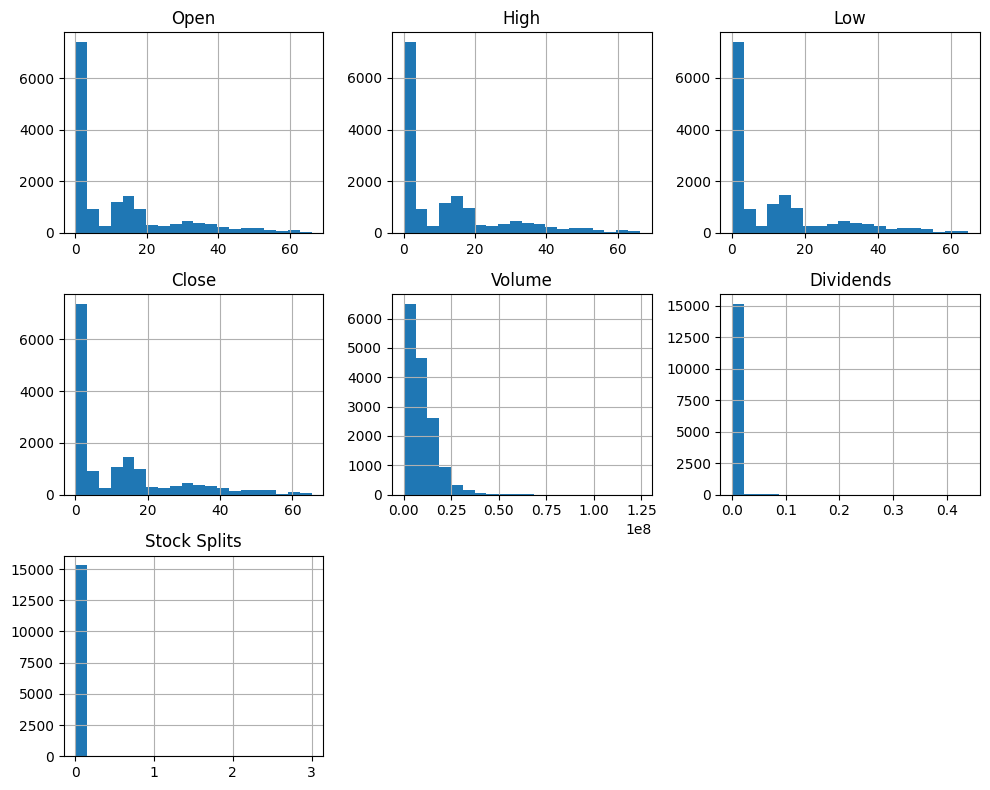

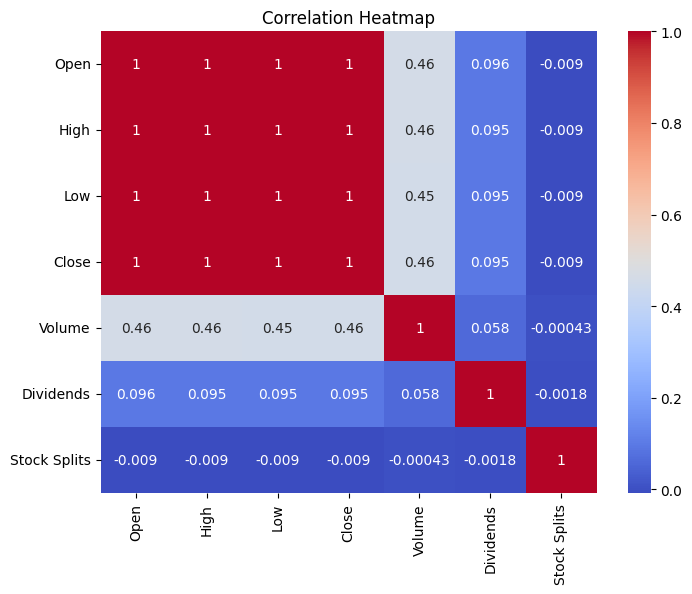

In [4]:
#  Simple EDA
print("Shape of data:", df.shape)
print("\nColumns:", df.columns)
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())
print("\nLast 5 rows:\n", df.tail())

#  Summary statistics
print("\nSummary statistics:\n", df.describe())

#  Check missing values
print("\nMissing values:\n", df.isnull().sum())

#  Value counts for categorical columns
# Assuming 'Date' is converted to datetime, there are no other object type columns
# If there were, you would iterate through df.select_dtypes(include='object').columns

#  Simple visualizations
# Histogram for numerical columns
df.hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

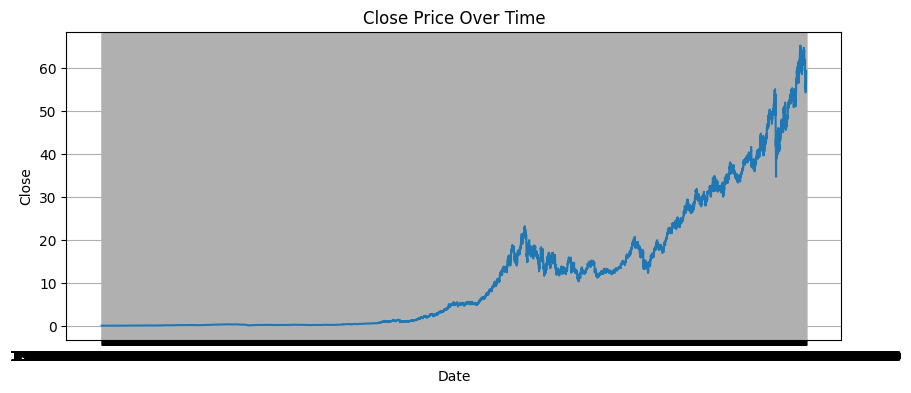

In [5]:
#  Plot Close price over time
if 'Close' not in df.columns:
    raise ValueError('CSV must have a Close column')

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.show()

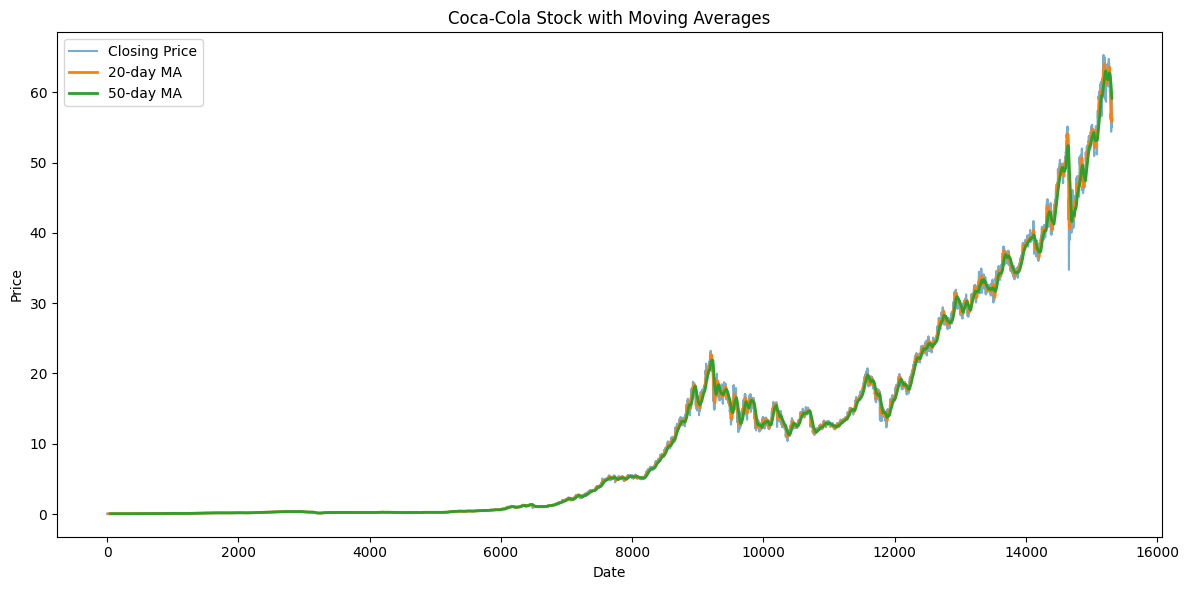

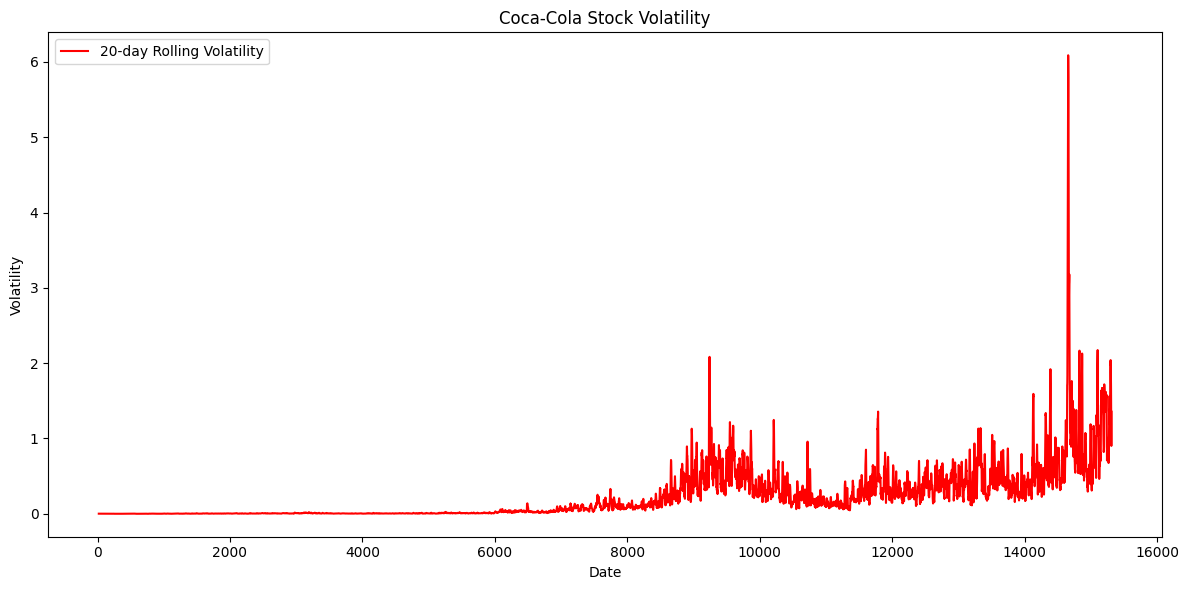

In [6]:
#  Moving Averages

df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Closing Price', alpha=0.6)
plt.plot(df.index, df['MA20'], label='20-day MA', linewidth=2)
plt.plot(df.index, df['MA50'], label='50-day MA', linewidth=2)
plt.title("Coca-Cola Stock with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


# Volatility (Rolling Std Dev)

df['Volatility'] = df['Close'].rolling(window=20).std()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Volatility'], color="red", label="20-day Rolling Volatility")
plt.title("Coca-Cola Stock Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [7]:
#  Feature engineering (very simple, easy to understand)

file_name = "Coca-Cola_stock_history.csv"
df = pd.read_csv(file_name)

data = df[['Date','Close']].copy()
if 'Volume' in df.columns:
    data['Volume'] = df['Volume']
else:
    data['Volume'] = 0  # placeholder if not present

# features
data['lag_1'] = data['Close'].shift(1)
data['return_1'] = data['Close'].pct_change(1)
data['ma5'] = data['Close'].rolling(window=5, min_periods=1).mean()
data['ma10'] = data['Close'].rolling(window=10, min_periods=1).mean()

# drop rows with NaN from lag/return
data = data.dropna().reset_index(drop=True)
print('After feature creation — shape:', data.shape)
print(data.head())

After feature creation — shape: (15310, 7)
         Date     Close   Volume     lag_1  return_1       ma5      ma10
0  1962-01-03  0.048902  1574400  0.050016 -0.022280  0.049459  0.049459
1  1962-01-04  0.049273   844800  0.048902  0.007598  0.049397  0.049397
2  1962-01-05  0.048159  1420800  0.049273 -0.022616  0.049087  0.049087
3  1962-01-08  0.047664  2035200  0.048159 -0.010282  0.048803  0.048803
4  1962-01-09  0.048530   960000  0.047664  0.018181  0.048505  0.048757


In [8]:
#  Prepare train/test sets (time-based split)
file_name = "Coca-Cola_stock_history.csv"
df = pd.read_csv(file_name)

# --- Detect a date column automatically ---
date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

if date_cols:
    date_col = date_cols[0]   # take the first match
    print(f"Detected date column: '{date_col}'")

    # Parse as datetime safely, handle mixed formats & timezones
    df[date_col] = pd.to_datetime(
        df[date_col],
        errors='coerce',   # invalid dates -> NaT
        utc=True           # avoid mixed timezone warnings
    )

    # Sort by date
    df = df.sort_values(by=date_col).reset_index(drop=True)

else:
    date_col = None
    print("No date-like column detected. Using row index instead.")


# Parse 'Date' with 'mixed' format to handle different date string variations
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')

# Define features and target columns
FEATURES = ['Open', 'High', 'Low', 'Volume']  # adjust depending on your CSV
TARGET = 'Close'

# Make sure columns exist in df
existing_features = [f for f in FEATURES if f in df.columns]
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in CSV.")

# Prepare data
data = df[existing_features + [TARGET]].copy()
X = data[existing_features].values
y = data[TARGET].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Detected date column: 'Date'
Features shape: (15311, 4)
Target shape: (15311,)


In [9]:
from sklearn.model_selection import train_test_split

features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

X = df[features]
y = df[target]

#  Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#  Predict
y_pred = model.predict(X_test)

#  Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" Mean Absolute Error (MAE): {mae:.2f}")

 Mean Squared Error (MSE): 0.01
 Mean Absolute Error (MAE): 0.05


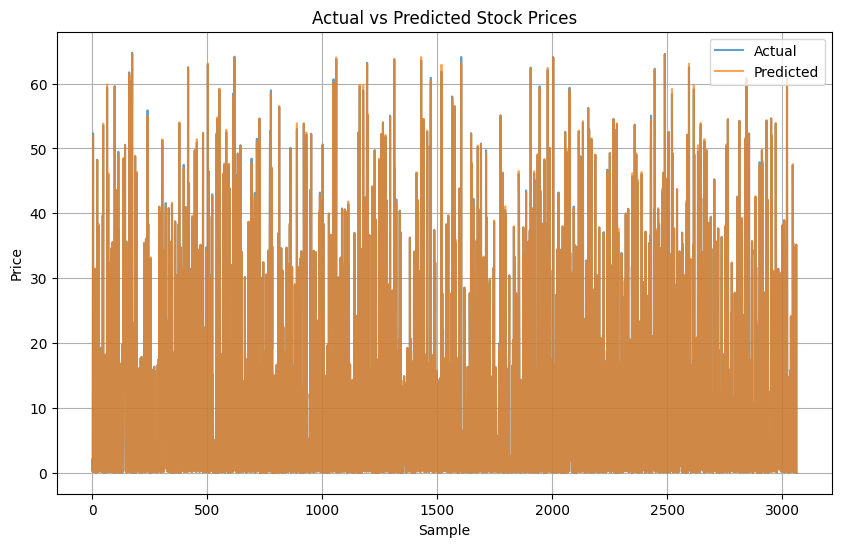

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Rows total: 6471  |  Train: 5176  |  Test: 1295
Mean Squared Error (test): 289.899173
R2 Score (test): -0.885079
y_test variance: 153.78622229344424
Any duplicated rows in X_test? False
        Date  Close_true  Close_pred
0 2007-03-06   14.477320     14.4646
1 2007-03-07   14.421792     14.4552
2 2007-03-08   14.545183     14.5624
3 2007-03-09   14.674749     14.6432
4 2007-11-05   18.988535     19.0392


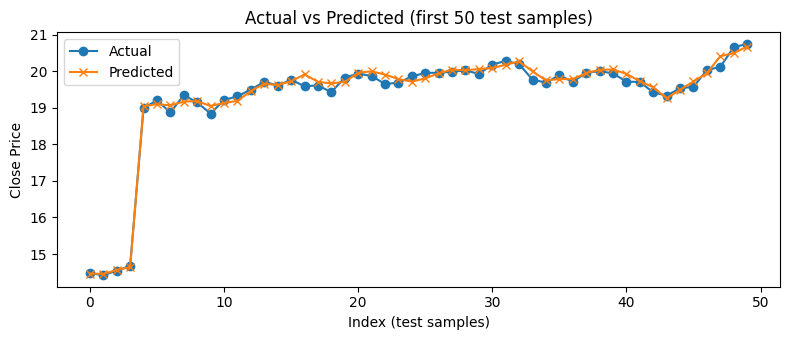

In [11]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
df = df.dropna(subset=['Date']).reset_index(drop=True)

#  Ensure numeric and drop rows missing core numeric columns
for c in ['Open','High','Low','Close','Volume']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['Open','High','Low','Close','Volume']).sort_values('Date').reset_index(drop=True)

#  Features / target (no leakage)
features = ['Open','High','Low','Volume']
X = df[features]
y = df['Close']
assert 'Close' not in X.columns

#  Time-based split (80/20)
n = len(df)
split = int(0.8 * n)
if split == n or split == 0:
    raise ValueError("Train/test split produced empty set — check dataset length.")
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

#  Train & evaluate (predict only on test set)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Rows total: {n}  |  Train: {len(X_train)}  |  Test: {len(X_test)}")
print(f"Mean Squared Error (test): {mse:.6f}")
print(f"R2 Score (test): {r2:.6f}")

#  Quick sanity checks (short)
print("y_test variance:", float(np.var(y_test)))
print("Any duplicated rows in X_test?", X_test.duplicated().any())

#  Small comparison preview
comp = pd.DataFrame({
    'Date': df['Date'].iloc[split:].reset_index(drop=True),
    'Close_true': y_test.reset_index(drop=True),
    'Close_pred': np.round(y_pred, 4)
})
print(comp.head(5))

#  Compact plot (first 50 test samples)
plt.figure(figsize=(8,3.5))
plt.plot(y_test.iloc[:50].values, marker='o', label='Actual')
plt.plot(y_pred[:50], marker='x', label='Predicted')
plt.title("Actual vs Predicted (first 50 test samples)")
plt.xlabel("Index (test samples)")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Train a Random Forest (stronger, still simple)

# Make sure X_train, X_test, y_train, and y_test are available from previous cell execution (Sth4CEdJQgpJ)
if 'X_train' not in globals() or 'X_test' not in globals() or 'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Training and testing data (X_train, X_test, y_train, y_test) not found. Please run cell Sth4CEdJQgpJ first.")
else:
    # Initialize and train the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    ypred_rf = rf.predict(X_test)

    # Evaluate the Random Forest model
    mae_rf = mean_absolute_error(y_test, ypred_rf)
    mse_rf = mean_squared_error(y_test, ypred_rf)
    rmse_rf = np.sqrt(mse_rf)

    print(f'Random Forest — MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}')

    # Optional: Calculate R2 for Random Forest
    r2_rf = r2_score(y_test, ypred_rf)
    print(f'Random Forest — R2 Score: {r2_rf:.4f}')

Random Forest — MAE: 12.6396, RMSE: 17.0264
Random Forest — R2 Score: -0.8851


 Using 'Date' as the date column.


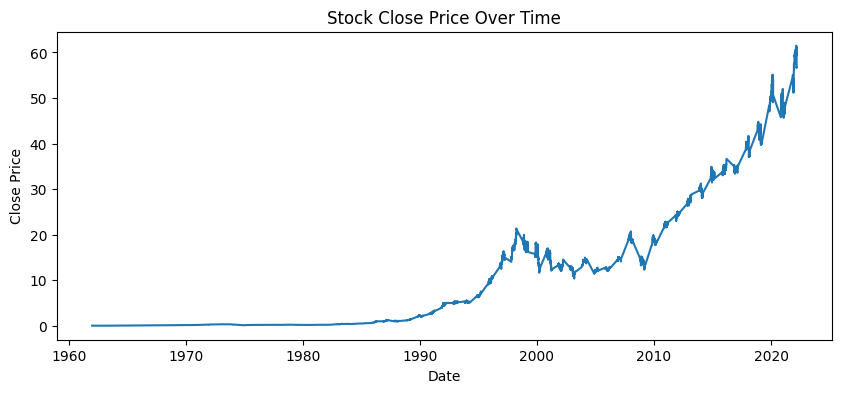

In [13]:
#  Plot Actual vs Predicted (test period)
date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

if date_cols:
    date_col = date_cols[0]  # pick the first candidate
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(by=date_col)
    print(f" Using '{date_col}' as the date column.")

    # Example plot
    plt.figure(figsize=(10,4))
    plt.plot(df[date_col], df['Close'])
    plt.title("Stock Close Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.show()

else:
    print(" No date-like column found. Plotting by index instead.")

    # Fallback plot (index vs Close)
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df['Close'])
    plt.title("Stock Close Price Over Index")
    plt.xlabel("Index")
    plt.ylabel("Close Price")
    plt.show()


In [14]:
rf_model_varname = 'model'        # change to the variable name of your RandomForestRegressor if different
lr_disk_path = 'linear_model.joblib'
rf_disk_path = 'rf_model.joblib'  # optional if you save/load RF

#  Ensure feature list is defined (must match training) ---
features = ['Open','High','Low','Volume']

# If you already have a trained RandomForest in a variable, use it; otherwise try to load from disk
try:
    rf_model = globals()[rf_model_varname]
except Exception:
    if os.path.exists(rf_disk_path):
        rf_model = joblib.load(rf_disk_path)
    else:
        raise RuntimeError(f"RandomForest model '{rf_model_varname}' not found in memory and '{rf_disk_path}' not found on disk.")

#  Ensure Linear Regression model (lr) exists; if not, train a simple one and save it ---
if 'lr' not in globals():
    # Requires X_train, y_train in the environment
    if 'X_train' not in globals() or 'y_train' not in globals():
        raise RuntimeError("Linear model 'lr' missing and X_train/y_train are not available in the notebook. Run the training cell first.")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    joblib.dump(lr, lr_disk_path)
    print("Trained & saved LinearRegression as 'lr' ->", lr_disk_path)
else:
    lr = globals()['lr']
    # optionally persist
    joblib.dump(lr, lr_disk_path)

#  Prepare single-sample input (ensure DataFrame with same feature names) ---
# Example: replace these values with your actual "next-sample" features
sample_values = {'Open': 21.0, 'High': 21.5, 'Low': 20.8, 'Volume': 1500000}

# Build DataFrame with exact column order/names used during training
sample_df = pd.DataFrame([sample_values], columns=features)

#  Predict with both models (no warnings because we passed DataFrame with correct names) ---
rf_pred = rf_model.predict(sample_df)
lr_pred = lr.predict(sample_df)

print(f"Predicted next close — RandomForest: {rf_pred[0]:.4f}")
print(f"Predicted next close — LinearReg : {lr_pred[0]:.4f}")


Trained & saved LinearRegression as 'lr' -> linear_model.joblib
Predicted next close — RandomForest: 21.2854
Predicted next close — LinearReg : 21.2686


[*********************100%***********************]  1 of 1 completed

Epoch 1/20


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0650
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0061
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0047
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0035
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0033
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0031
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0029
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021
Epoch 16/20
38/

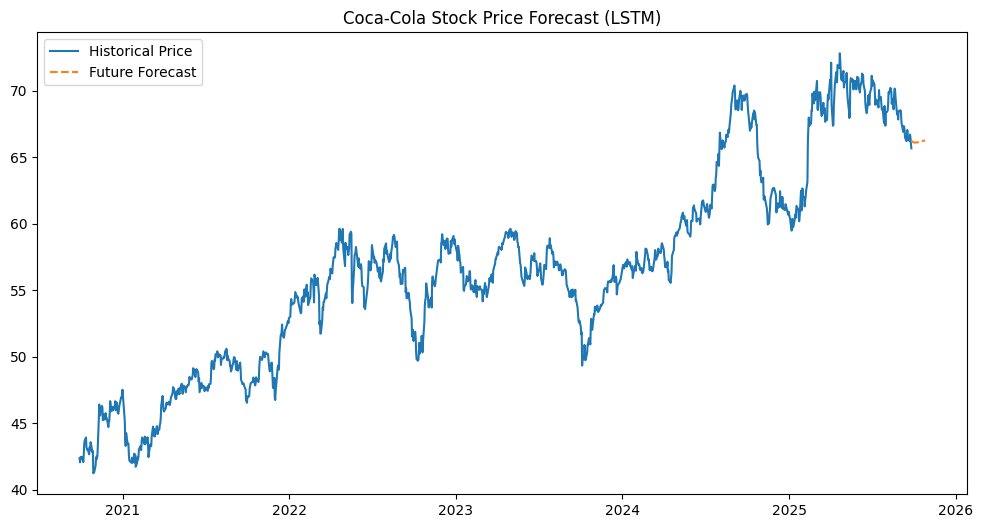

            Predicted
Date                 
2025-09-27  66.245552
2025-09-28  66.189011
2025-09-29  66.152893
2025-09-30  66.130226
2025-10-01  66.116493


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input

# Download Coca-Cola data
df = yf.download("KO", period="5y", interval="1d", auto_adjust=True)
data = df[['Close']].values

# Normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM Model
model = Sequential([
    Input(shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, batch_size=32, epochs=20, verbose=1)

# Multi-step forecast
future_days = 30
last_sequence = scaled_data[-sequence_length:]   # last 60 days
future_predictions = []

for _ in range(future_days):
    seq = np.reshape(last_sequence, (1, sequence_length, 1))
    pred = model.predict(seq, verbose=0)
    future_predictions.append(pred[0,0])

    # append prediction and remove first value
    last_sequence = np.append(last_sequence, pred)[-sequence_length:]

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

forecast_df = pd.DataFrame({"Date": future_dates, "Predicted": future_predictions.flatten()})
forecast_df.set_index("Date", inplace=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Historical Price")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="Future Forecast", linestyle="dashed")
plt.title("Coca-Cola Stock Price Forecast (LSTM)")
plt.legend()
plt.show()

print(forecast_df.head())